In [1]:
import tensorflow as tf
import os

In [2]:
import cv2
import imghdr

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data'

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
os.listdir(data_dir)

['happy', 'sad']

In [11]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

LOAD DATASET


In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/data')

Found 880 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

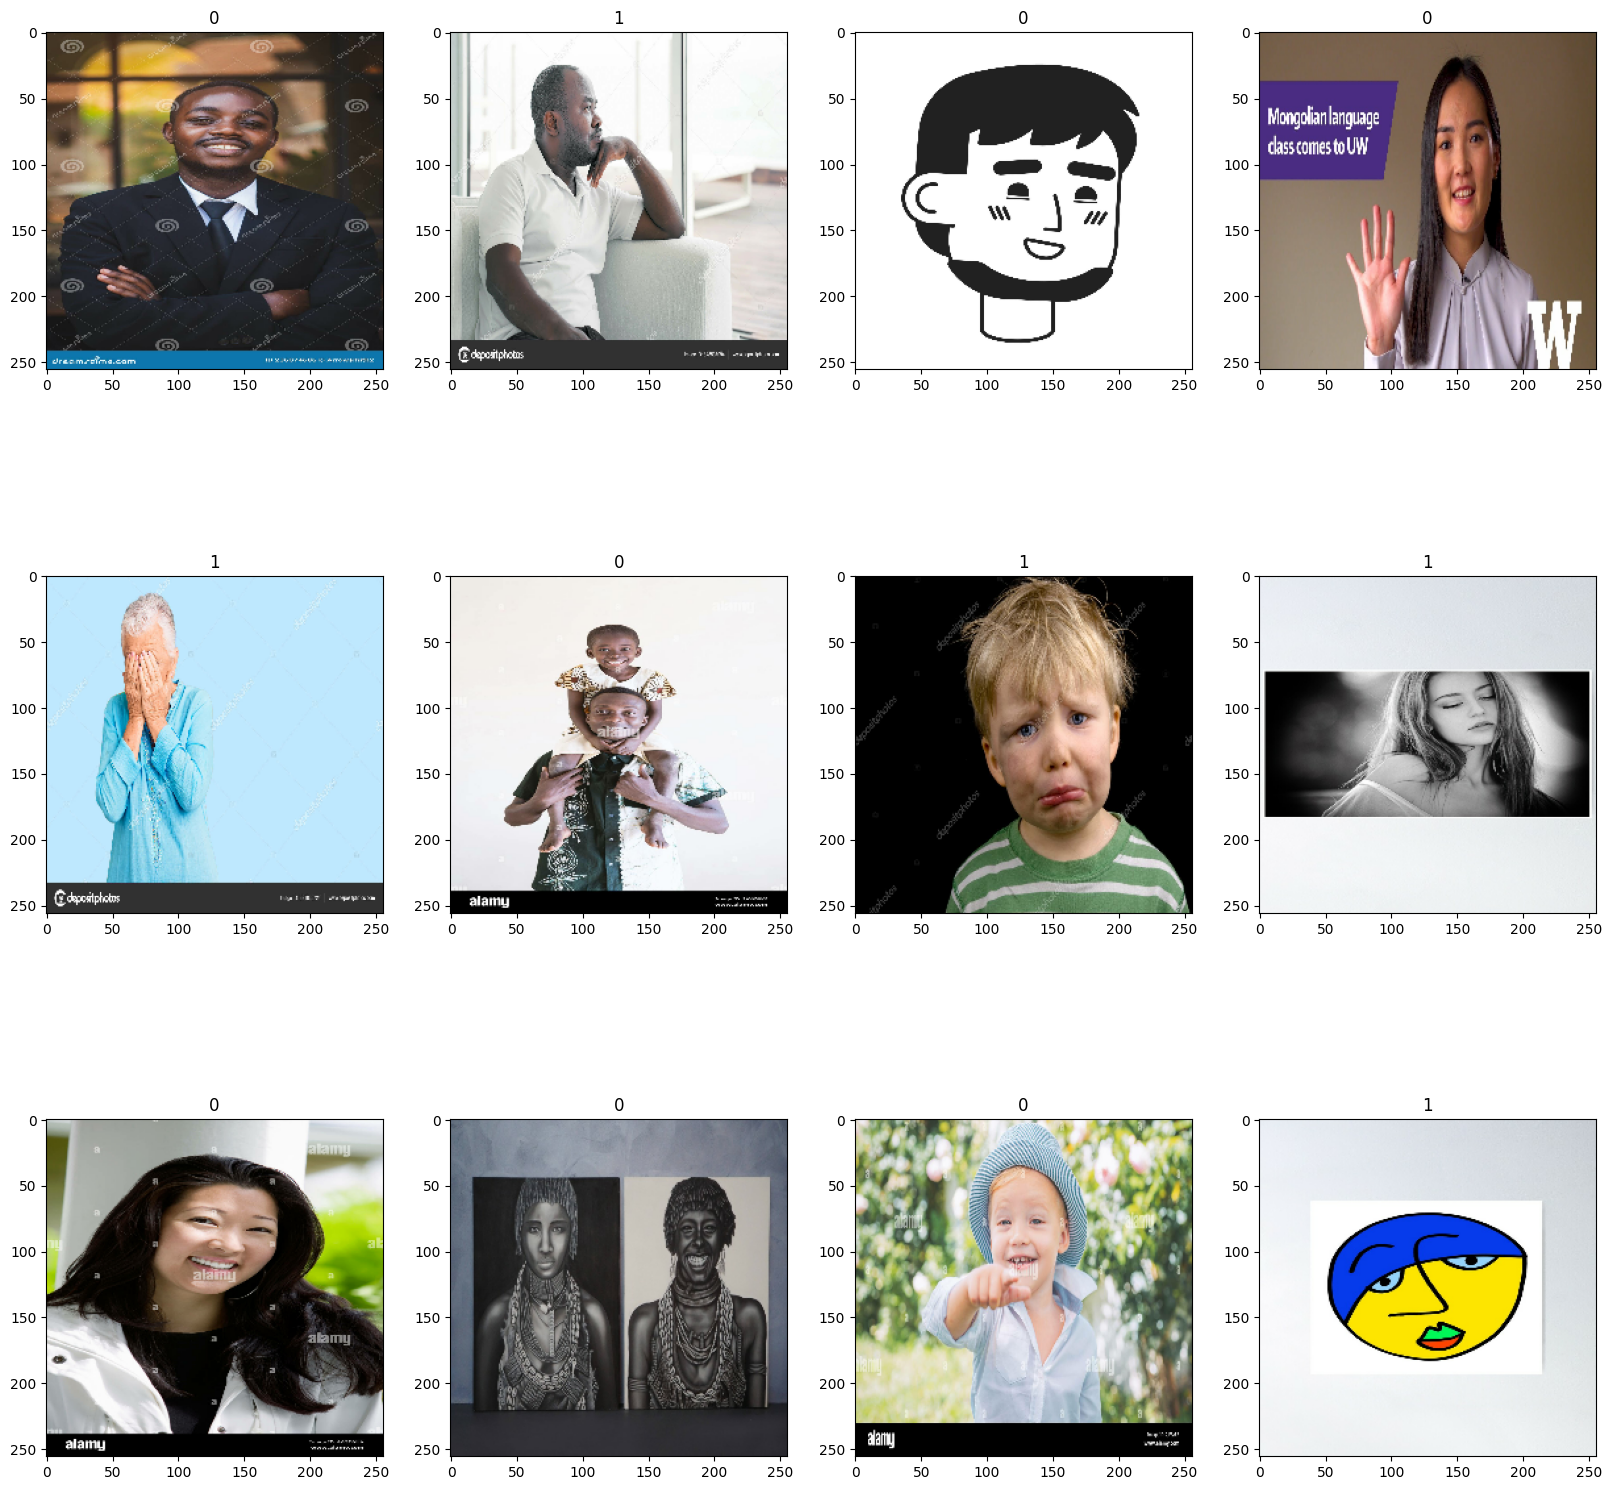

In [16]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20, 20))
for idx, img in enumerate(batch[0][:12]):
    ax[idx // 4, idx % 4].imshow(img.astype(int))
    ax[idx // 4, idx % 4].title.set_text(batch[1][idx])
plt.show()

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[0.49649522, 0.4729658 , 0.38669127],
          [0.57589644, 0.55236703, 0.49746507],
          [0.5891677 , 0.5656383 , 0.50566584],
          ...,
          [0.8156863 , 0.80784315, 0.75686276],
          [0.8156863 , 0.80784315, 0.75686276],
          [0.8156863 , 0.80784315, 0.75686276]],
 
         [[0.62468135, 0.5849908 , 0.48718902],
          [0.6290683 , 0.6094605 , 0.5305542 ],
          [0.47730228, 0.4498513 , 0.4122042 ],
          ...,
          [0.8156863 , 0.80784315, 0.75686276],
          [0.8156863 , 0.80784315, 0.75686276],
          [0.8156863 , 0.80784315, 0.75686276]],
 
         [[0.5534374 , 0.52598643, 0.45371315],
          [0.6264859 , 0.6029565 , 0.50883883],
          [0.641179  , 0.61372805, 0.5431398 ],
          ...,
          [0.8156863 , 0.80784315, 0.75686276],
          [0.8156863 , 0.80784315, 0.75686276],
          [0.8156863 , 0.80784315, 0.75686276]],
 
         ...,
 
         [[0.13333334, 0.13333334, 0.13333334],
          [0.13333

In [19]:
len(data)

28

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling

In [25]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
19/19 [==============================] - 60s 3s/step - loss: 0.6779 - accuracy: 0.5938 - val_loss: 0.6668 - val_accuracy: 0.6375
Epoch 2/2
19/19 [==============================] - 63s 3s/step - loss: 0.6483 - accuracy: 0.6826 - val_loss: 0.6681 - val_accuracy: 0.5875


In [31]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

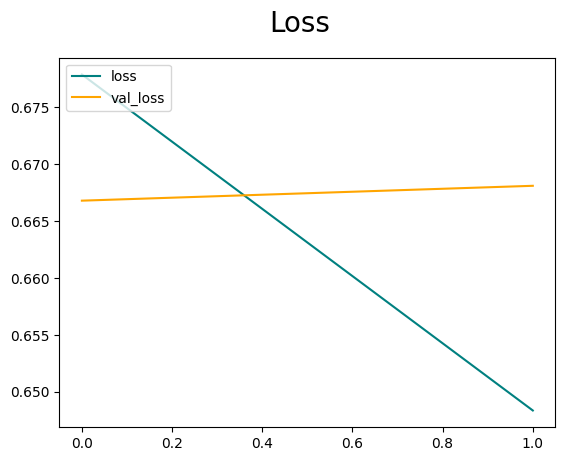

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

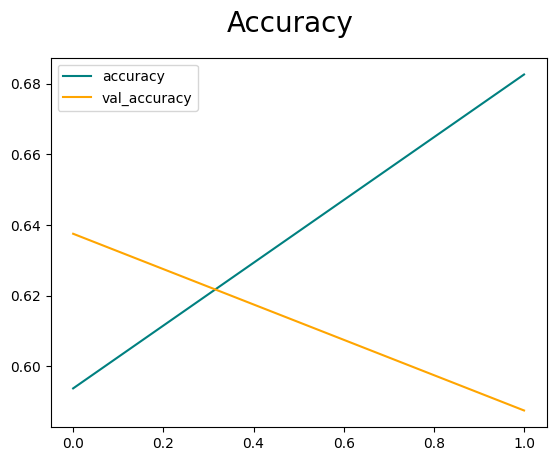

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 450ms/step


In [37]:
print(f'Precision:{pre.result().numpy()}, Recal:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.5, Recal:0.8461538553237915, Accuracy:0.59375


In [38]:
import cv2

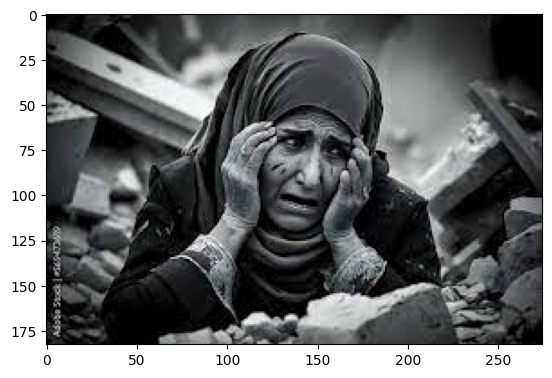

In [39]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/img_test/sad_test/descarga (2).jpeg')
plt.imshow(img)
plt.show()

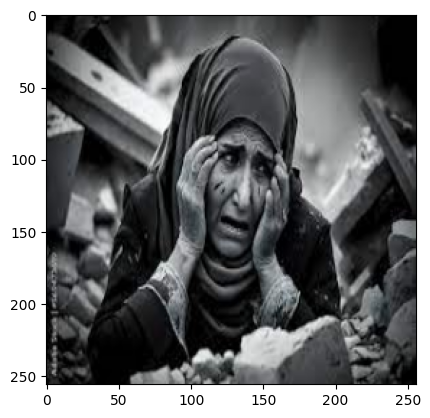

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
np.expand_dims(resize, axis=0).shape

(1, 256, 256, 3)

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 455ms/step


In [43]:
yhat

array([[0.8763415]], dtype=float32)

In [44]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('/content/drive/MyDrive/Colab Notebooks','imageclassifier.h5'))

In [74]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/imageclassifier.h5')

SELF DATA PREDICTION

In [75]:
import cv2

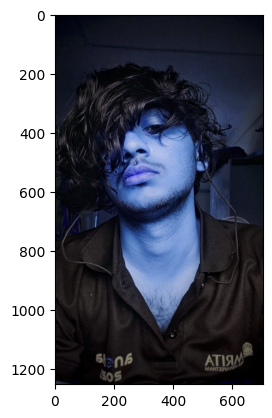

In [86]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dukhbc.jpeg')
plt.imshow(img)
plt.show()

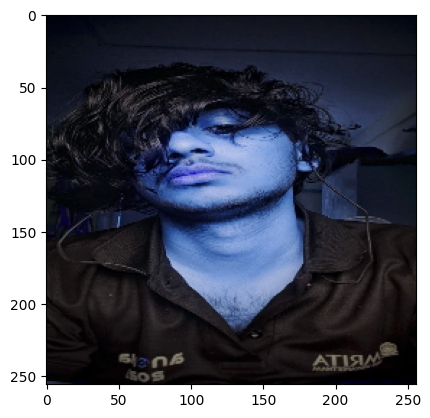

In [87]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [88]:
np.expand_dims(resize, axis=0).shape

(1, 256, 256, 3)

In [89]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 37ms/step


In [90]:
yhat

array([[0.8905875]], dtype=float32)

In [91]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [101]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [102]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [103]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [109]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


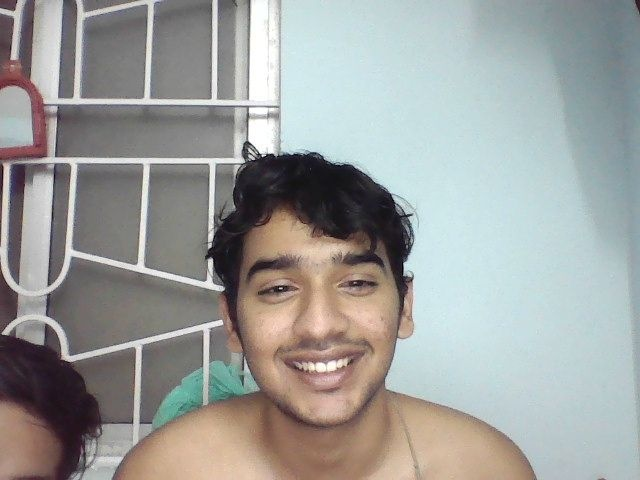

In [116]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

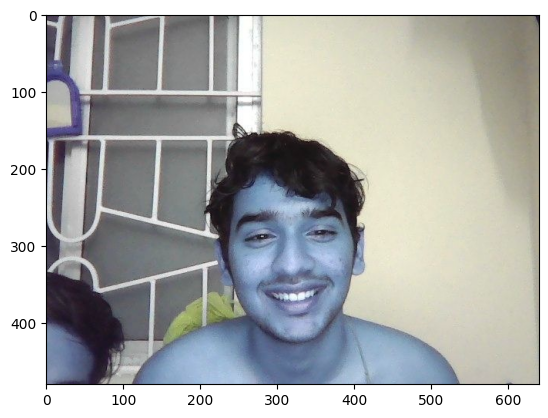

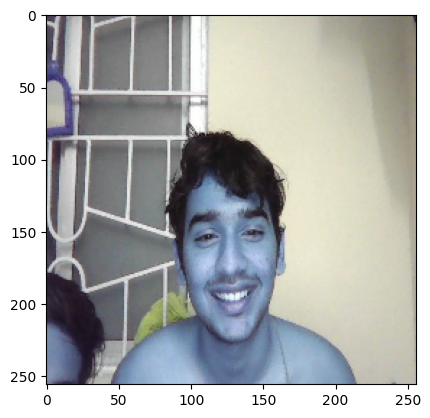

In [117]:
live = cv2.imread('/content/photo.jpg')
plt.imshow(live)
plt.show()
resize = tf.image.resize(live, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [118]:
np.expand_dims(resize, axis=0).shape

(1, 256, 256, 3)

In [119]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 43ms/step


In [120]:
yhat

array([[0.48049194]], dtype=float32)

In [121]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
